# Figure: input signal & architecture

Code to generate parts of the figure in the main text.

Based on a pared-down version of the starting notebook.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

## Sound localization stimuli

The following function creates a set of stimuli that can be used for training or testing.

We have two ears (0 and 1), and ear 1 will get a version of the signal delayed by an IPD we can write as $\alpha$ in equations (``ipd`` in code).

The basic signal is a sine wave made positive, so $(1/2)(1+\sin(\theta))$.

In addition, for each ear there will be $N_a$ neurons per ear (``anf_per_ear`` because these are auditory nerve fibres).

Each neuron generates Poisson spikes at a certain firing rate, and these Poisson spike trains are independent.\
In addition, since it is hard to train delays, we seed it with uniformly distributed delays from a minimum of 0 to a maximum of $\pi/2$ in each ear, so that the differences between the two ears can cover the range of possible IPDs ($-\pi/2$ to $\pi/2$). We do this directly by adding a phase delay to each neuron.

So for ear $i\in\{0,1\}$ and neuron $j$ at time $t$ the angle $\theta=2\pi f t+i\alpha+j\pi/2N_a$.

Finally, we generate Poisson spike trains with a rate $R_\mathrm{max}((1/2)(1+\sin(\theta)))^k$.
- $R_\mathrm{max}$ (``rate_max``) is the maximum instantaneous firing rate, and
- $k$ (``envelope_power``) is a constant that sharpens the envelope.

The higher $R_\mathrm{max}$ and $k$ the easier the problem.

Here's a picture of the architecture for the stimuli:

<img width=500 src="diagrams/arch-stimuli.png">

The functions below return two arrays ``ipd`` and ``spikes``.
- ``ipd`` is an array of length ``num_samples`` that gives the true IPD, and
- ``spikes`` is an array of 0 (no spike) and 1 (spike) of shape ``(num_samples, duration_steps, 2*anf_per_ear)``, where ``duration_steps`` is the number of time steps there are in the stimulus.

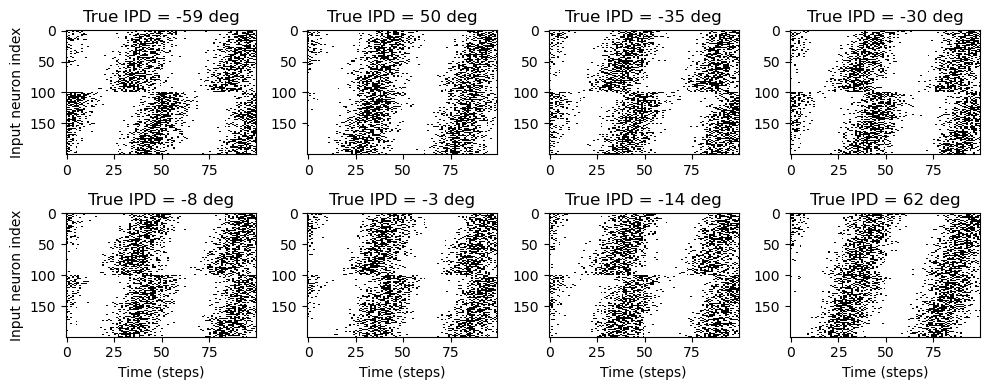

In [85]:
# Not using Brian so we just use these constants to make equations look nicer below
second = 1
ms = 1e-3
Hz = 1

# Stimulus and simulation parameters
dt = 1*ms            # large time step to make simulations run faster for tutorial
anf_per_ear = 100    # repeats of each ear with independent noise
envelope_power = 2   # higher values make sharper envelopes, easier
rate_max = 600*Hz   # maximum Poisson firing rate
f = 20*Hz            # stimulus frequency
duration = .1*second # stimulus duration
duration_steps = int(np.round(duration/dt))
input_size = 2*anf_per_ear

# Generate an input signal (spike array) from array of true IPDs
def input_signal(ipd):
    num_samples = len(ipd)
    T = np.arange(duration_steps)*dt # array of times
    phi = 2*np.pi*(f*T+np.random.rand()) # array of phases corresponding to those times with random offset
    # each point in the array will have a different phase based on which ear it is
    # and its delay
    theta = np.zeros((num_samples, duration_steps, 2*anf_per_ear))
    # for each ear, we have anf_per_ear different phase delays from 0 to pi/2 so
    # that the differences between the two ears can cover the full range from -pi/2 to pi/2
    phase_delays = np.linspace(0, np.pi/2, anf_per_ear)
    # now we set up these theta to implement that. Some numpy vectorisation logic here which looks a little weird,
    # but implements the idea in the text above.
    theta[:, :, :anf_per_ear] = phi[np.newaxis, :, np.newaxis] + phase_delays[np.newaxis, np.newaxis, :]
    theta[:, :, anf_per_ear:] = phi[np.newaxis, :, np.newaxis] + phase_delays[np.newaxis, np.newaxis, :] + ipd[:, np.newaxis, np.newaxis]
    # now generate Poisson spikes at the given firing rate
    spikes = np.random.rand(num_samples, duration_steps, 2*anf_per_ear) < rate_max*dt*(0.5*(1+np.sin(theta)))**envelope_power
    return spikes, phi

# Generate some true IPDs from U(-pi/2, pi/2) and corresponding spike arrays
def random_ipd_input_signal(num_samples):
    ipd = np.random.rand(num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
    spikes = input_signal(ipd)[0]
    return ipd, spikes

# Plot a few just to show how it looks
ipd, spikes = random_ipd_input_signal(8)
plt.figure(figsize=(10, 4), dpi=100)
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
    plt.title(f'True IPD = {int(ipd[i]*180/np.pi)} deg')
    if i>=4:
        plt.xlabel('Time (steps)')
    if i%4==0:
        plt.ylabel('Input neuron index')
plt.tight_layout()

I think there is a little error here: the delays should have been subtracted instead of added (?).\

Take a peak of the first anf, `0` (say at IPD = 50°, t ≈ 45).\
The other ANF's of that ear (up to anf `99`) should have that same peak _later_ in time; but they have it earlier.

This is not really a problem (just relabel the neurons mentally, so that anf `99` receives the original signal, and anf `0` that signal delayed by 90°), it's just a little confusing.

## Select one IPD

In [86]:
ipd = np.pi * 0.2

ipd * 180/np.pi

36.0

In [162]:
np.random.seed(123414)
spikes, phi = input_signal(np.array([ipd]));
spikes.shape

(1, 100, 200)

(IPD, time, ANF)

In [163]:
def spiketrains(anf_nrs):
    # Convert dense {0,1} array to spiketime array
    spiketrain_list = []
    for anf in anf_nrs:
        spiketrain_list.append(np.nonzero(spikes[0, :, anf])[0])
    return spiketrain_list

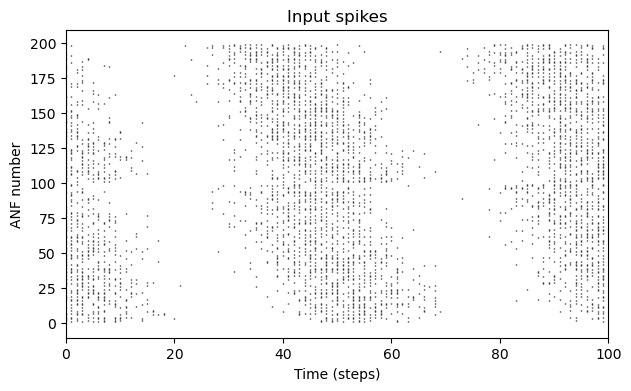

In [189]:
def rasterplot(trains, ax, title="Input spikes"):
    ax.eventplot(trains, colors="black", lw=1, linelengths = 0.5);
    ax.set(xlim=(0,100), xlabel="Time (steps)", ylabel="ANF number", title=title);

fig, ax = plt.subplots(figsize=(7,4))
rasterplot(spiketrains(np.arange(0,200,1)), ax)

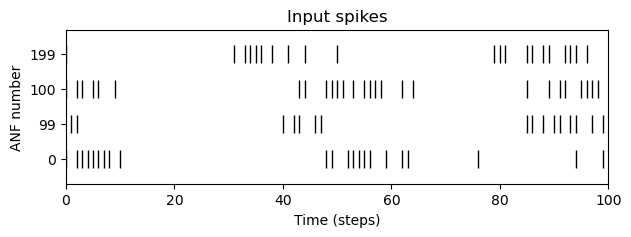

In [191]:
anfs = [0,99, 100,199]

fig, ax = plt.subplots(figsize=(7,2))
rasterplot(spiketrains(anfs), ax)
ax.set_yticks(np.arange(len(anfs)), anfs)
plt.savefig(Path("~/Desktop/spikes.svg").expanduser())

In [192]:
phase_delays = np.linspace(0, np.pi/2, anf_per_ear)

ipd_arr = ipd * np.ones_like(phase_delays)
theta = np.empty((len(phi), 2*anf_per_ear))
theta[:, :anf_per_ear] = phi[:,np.newaxis] + phase_delays[np.newaxis,:]
theta[:, anf_per_ear:] = phi[:,np.newaxis] + phase_delays[np.newaxis,:] + ipd_arr[np.newaxis,np.newaxis]

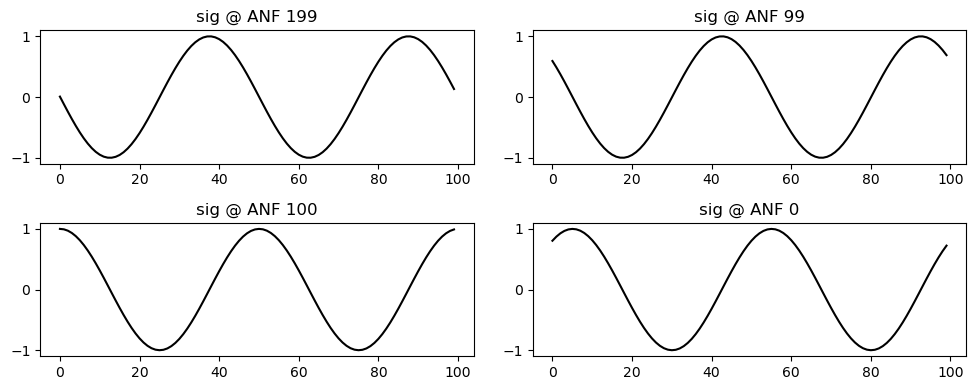

In [193]:
fig, axs = plt.subplots(figsize=(10,4), nrows=2, ncols=2)
for (i,anf) in enumerate(anfs):
    ax = axs.transpose().flatten()[3-i]
    ax.plot(np.sin(theta[:,anf]), "k");
    ax.set(title=f"sig @ ANF {anf}")
plt.tight_layout()
plt.savefig(Path("~/Desktop/sines.svg").expanduser())